In [1]:
using Combinatorics
using LinearAlgebra
using StatsBase
using Profile
using Plots
using Statistics

# Wrappers

In [2]:
#reward values
@enum RewardVal begin
    winReward = 100
    drawReward = 0
    loseReward = -100
end

In [3]:
@enum Marker begin
    E = 0
    X = 1
    O = 2
end

In [4]:
# The current tiles on a board
mutable struct BoardInstance
    n::Int64 # Board dimension (number of spaces per side)
    board::Array{Marker,2} # Current markers on the board
    emptyTiles::Array{CartesianIndex} # Tiles on the board that are currently empty
end

In [5]:
# Define a tictactoe game
mutable struct TicTacToeGame
    n::Int64 # Board dimension (number of spaces per side)
    state::BoardInstance # Current state of the board
end

In [6]:
struct Player
    marker::Marker # Whether the player is an X or O
end

In [7]:
function getFirstBoardInstance(n::Int64)
    board = fill(E, n, n)
    emptyTiles = findall(i->i in [X E O], board)
    return BoardInstance(n,board,emptyTiles)
end

getFirstBoardInstance (generic function with 1 method)

In [8]:
mutable struct Cache
    R_sa::Dict{Tuple{Array{Marker,2}, CartesianIndex}, Int64} # Stores reward results of board,action pairs
    W_sp::Dict{Tuple{Array{Marker,2}, Player}, Bool} # Stores winning results of state,player pairs
    A_s::Dict{Array{Marker,2}, Array{CartesianIndex}} # Stores action spaces for states
    S_sa::Dict{Tuple{Array{Marker,2}, CartesianIndex}, Array{BoardInstance}} # Stores state spaces for state action pairs
end

In [9]:
function createCache()
   return Cache( Dict{Tuple{Array{Marker,2}, CartesianIndex}, Int64}(),
        Dict{Tuple{Array{Marker,2}, Player}, Bool}(),
        Dict{Array{Marker,2}, Array{CartesianIndex}}(),
        Dict{Tuple{Array{Marker,2}, CartesianIndex}, Array{BoardInstance}}()) 
end

createCache (generic function with 1 method)

# MDP Functions

In [10]:
# Create a list of current possible locations to put an X
function getReachableActionSpace(boardInstance::BoardInstance, cache::Cache)
    # Check the cache
    if haskey(cache.A_s, boardInstance.board)
        return cache.A_s[boardInstance.board]
    end
    
    if length(boardInstance.emptyTiles) == boardInstance.n*boardInstance.n
        prunedTiles = CartesianIndex[]
        cutoffIndex = Int64(ceil(boardInstance.n/2))
        for tile in boardInstance.emptyTiles
            if ( (tile[1] <= cutoffIndex) && (tile[2] <= cutoffIndex))
                append!(prunedTiles, [tile])
            end
        end
        cache.A_s[boardInstance.board] = copy(prunedTiles)
        return prunedTiles
    else
        # Can place an X in any empty tile
        cache.A_s[boardInstance.board] = copy(boardInstance.emptyTiles)
        return boardInstance.emptyTiles
    end
end

getReachableActionSpace (generic function with 1 method)

In [11]:
# # Test getReachableActionSpace
# board = [X E E; O X X; O O E]

# boardInstance = getFirstBoardInstance(5)
# getReachableActionSpace(boardInstance)

In [12]:
# Create all potential next states given the current state of the game
# S'(s,a)
function getReachableStateSpace(boardInstance::BoardInstance, action::CartesianIndex, cache::Cache)    
    # Check the cache
    if haskey(cache.S_sa, (boardInstance.board, action))

        return cache.S_sa[(boardInstance.board, action)]
    end
    
    # Prepare a template for new boards with the new X filled in
    newBoardInstanceTemplateTiles = copy(boardInstance.board)
    newBoardInstanceTemplateTiles[action] = X
    newBoardInstanceTemplateEmptyTiles = [tile for tile in boardInstance.emptyTiles if tile != action]
    newBoardInstanceTemplate = BoardInstance( boardInstance.n, 
                    newBoardInstanceTemplateTiles, newBoardInstanceTemplateEmptyTiles )
    
    # Initialize an array of new boards
#     newBoards = fill( newBoardTemplate, length(newBoardTemplate.emptyTiles) )
    reachableBoardInstances = BoardInstance[]
    
    # Fill out the new boards with possible opponent (O) actions
    
    for emptyTile in newBoardInstanceTemplate.emptyTiles
        newTiles = copy(newBoardInstanceTemplate.board)
        newTiles[emptyTile] = O
        newEmptyTiles = [tile for tile in newBoardInstanceTemplate.emptyTiles if tile != emptyTile]
        newBoardInstance = BoardInstance( newBoardInstanceTemplate.n, newTiles, newEmptyTiles, )
        append!(reachableBoardInstances, [newBoardInstance])
    end
    cache.S_sa[(boardInstance.board, action)] = [BoardInstance( reachableBoardInstance.n, 
                                    copy(reachableBoardInstance.board), copy(reachableBoardInstance.emptyTiles)) 
                                    for reachableBoardInstance in reachableBoardInstances]

    return reachableBoardInstances

end

getReachableStateSpace (generic function with 1 method)

In [13]:
# # Test getReachableStateSpace
# board = [X E E; O X X; O O E]
# emptyTiles = findall(x->x==E, board)
# boardInstance = BoardInstance(3, board, emptyTiles)
# actionSpace = getReachableActionSpace(boardInstance)
# for action in actionSpace
#     @show action
#     @show getReachableStateSpace(boardInstance, action)
# end

In [14]:
# Check whether the given player wins the given board instance
function checkWin(boardInstance::BoardInstance, player::Player, cache::Cache)
    
    # Check the cache
    if haskey(cache.W_sp, (boardInstance.board, player))
        return cache.W_sp[(boardInstance.board, player)]
    end
    
    playerWins = false

        
    if (all(marker -> marker == player.marker, diag(boardInstance.board)) || # Main diagonal
            all(marker -> marker == player.marker, diag(boardInstance.board[:,end:-1:1]))) # Opposite diagonal
        playerWins = true
    else
        for i = 1:boardInstance.n
            if (all(marker -> marker == player.marker, boardInstance.board[i,:]) || # Row
                all(marker -> marker == player.marker, boardInstance.board[:,i])) # Column
                

                playerWins = true
                break
            end
        end
    end
    cache.W_sp[(boardInstance.board, player)] = playerWins
    return playerWins
end
# reverse_board = map(Int, permutedims(reshape(reverse(state), game.n, game.n)))

checkWin (generic function with 1 method)

In [15]:
# # Test checkWin

# player = Player(X)

# board = [X E E; X E X; E E X]
# emptyTiles = findall(x->x==E, board)
# @show checkWin(BoardInstance(3, board, emptyTiles), player)

# board = [X E E; X E E; X E E]
# @show checkWin(BoardInstance(3, board, emptyTiles), player)

# board = [E X E; E X E; E X E]
# @show checkWin(BoardInstance(3, board, emptyTiles), player)

# board = [X E E; E X E; E E X]
# @show checkWin(BoardInstance(3, board, emptyTiles), player)

# board = [E E X; E X E; X E E]
# @show checkWin(BoardInstance(3, board, emptyTiles), player)

In [16]:
# Get a list of the transition probabilities for a set of reachable states
# T(s,a)
function getTransitionProbabilities(newBoardInstances::Array{BoardInstance}, cache::Cache)
    nNewBoardInstances = length(newBoardInstances)
    Ts = zeros(Float64, nNewBoardInstances)
    
    # Whether the opponent can make a winning move
    winningMoveExists = false;
    
    i = 1
    for newBoardInstance in newBoardInstances
        # The opponent will always take a winning move
        if checkWin(newBoardInstance, Player(O), cache)
            Ts[i] = 1
            winningMoveExists = true
            break
        end
        i += 1
    end
    
    # Uniform probability
    if !winningMoveExists
        Ts = fill(1.0/nNewBoardInstances, nNewBoardInstances)
    end
    
    return Ts
end

getTransitionProbabilities (generic function with 1 method)

In [17]:
# Test getReachableStateSpace
# board = [X E E; O X X; O O E]
# emptyTiles = findall(x->x==E, board)

# boardInstance = BoardInstance(3, board, emptyTiles)
# actionSpace = getReachableActionSpace(boardInstance)
# for action in actionSpace
#     @show action
#     @show stateSpace = getReachableStateSpace(boardInstance, action)
#     @show getTransitionProbabilities(stateSpace)
# end

In [18]:
function getReward(boardInstance::BoardInstance, action::CartesianIndex, 
        reachableBoardInstances::Array{BoardInstance}, cache::Cache)
    
    if haskey(cache.R_sa, (boardInstance.board, action))
       return cache.R_sa[(boardInstance.board, action)]
    end
    
    reward = 0
    newBoardInstance = BoardInstance( boardInstance.n, 
        copy(boardInstance.board), copy(boardInstance.emptyTiles))
    newBoardInstance.board[action] = X
    
    if checkWin(newBoardInstance, Player(X), cache)
        # Player will win by taking this move

        # We're not updating the empty tiles but it doesn't matter
        reward = winReward
    else        
        for reachableBoardInstance in reachableBoardInstances
            if checkWin(reachableBoardInstance, Player(O), cache)
                # Player will lose because opponent will make a winning move
                reward = loseReward
            end            
        end
    end
    
    cache.R_sa[(boardInstance.board, action)] = Int64(reward)
    return Int64(reward)

end

getReward (generic function with 1 method)

In [19]:
# # Test getReward
# board = [X E E; O X X; O E E]
# emptyTiles = findall(x->x==E, board)

# boardInstance = BoardInstance(3, board, emptyTiles)
# action = CartesianIndex(3,3)
# stateSpace = getReachableStateSpace(boardInstance, action)
# @show getReward(boardInstance, action, stateSpace)
# action = CartesianIndex(1,2)
# stateSpace = getReachableStateSpace(boardInstance, action)
# @show getReward(boardInstance, action, stateSpace)

# board = [X E E; O X X; O O E]
# boardInstance = BoardInstance(3, board, emptyTiles)
# action = CartesianIndex(1,2)
# stateSpace = getReachableStateSpace(boardInstance, action)
# @show getReward(boardInstance, action, stateSpace)

# board = [X E O; X E O; E E E]
# boardInstance = BoardInstance(3, board, emptyTiles)
# action = CartesianIndex(3,1)
# stateSpace = getReachableStateSpace(boardInstance, action)
# @show getReward(boardInstance, action, stateSpace)

# Monte Carlo

### Wrappers and Initializers

In [20]:
# initializes all structures/parameters before starting MCTS
# Dictionaries of N(s), N(s,a) and Q(s,a), exploration constant c
# 
mutable struct GameSimulation
    N_sa::Dict{Tuple{Array{Marker,2}, CartesianIndex}, Int64} # stores counts of board,action pairs
    N_s::Dict{Array{Marker,2}, Int64} # stores counts of each state
    Q_sa::Dict{Tuple{Array{Marker,2},CartesianIndex}, Float64} # total value of a board,action pair
    T::Set{Array{Marker,2}} # set of states we've seen
    c::Float64 # exploration constant (feel free to tweak/change!)
    gamma::Float64
    nIterations::Int64
end

In [21]:
# initialize players before starting
# player1 = Player(x, 1.0)
# player2 = Player(o, 1.0)
function getNewGameSim(c::Float64, gamma::Float64, numIterations::Int64)
    # Number of times we've taken an action from a state
    # Dictionary from (state,action) to count
    N_sa = Dict{Tuple{Array{Marker,2}, CartesianIndex}, Int64}()

    # Total number of actions we've taken from a state
    # Dictionary from state to count
    N_s = Dict{Array{Marker,2}, Int64}()

    # Value of taking an action from a state
    # Dictionary from (state,action) to value
    Q_sa = Dict{Tuple{Array{Marker,2},CartesianIndex}, Float64}()

    # Set of all states visited
    T = Set{Array{Marker,2}}()

    gameSim = GameSimulation(N_sa, N_s, Q_sa, T, c, gamma, numIterations)
    return gameSim
end

getNewGameSim (generic function with 1 method)

In [22]:
# Test getNewGameSim
# n = 3
# boardInstance = getFirstBoardInstance(n)
# gameSim = getNewGameSim(1.0, 1.0, 1000)

### Logic

In [23]:
function checkTerminalState(boardInstance::BoardInstance, cache::Cache)
    isTerminal = false
    
    if checkWin(boardInstance, Player(X), cache) || checkWin(boardInstance, Player(O), cache)
        # One of the players has won
        isTerminal = true
    elseif length(boardInstance.emptyTiles) in [0, 1]
        # No more moves are possible
        isTerminal = true
    end
    
    return isTerminal
end

checkTerminalState (generic function with 1 method)

In [24]:
# Exploration Function, i know this can be sped up, but its really
# slow right now
function explore(gameSim::GameSimulation, boardInstance::BoardInstance, cache::Cache)
    rewardMax = -Inf
    bestAction = CartesianIndex()
    
    # Maximize the cost function over all possible actions
    for action in getReachableActionSpace(boardInstance, cache)
        reward = gameSim.Q_sa[(boardInstance.board, action)] + 
            gameSim.c * sqrt(log(gameSim.N_s[boardInstance.board]) / 
            gameSim.N_sa[(boardInstance.board,action)])
        if reward > rewardMax
            rewardMax = reward
            bestAction = action
        end
    end
    return bestAction
end

explore (generic function with 1 method)

In [25]:
# Iterate over all the actions from this new state
function expand(gameSim::GameSimulation, boardInstance::BoardInstance, cache::Cache)
    gameSim.N_s[boardInstance.board] = 0 # initialize N_sa to our prior N_0 (0)
    for action in getReachableActionSpace(boardInstance, cache)
        gameSim.N_sa[(boardInstance.board,action)] = 1 # initialize N_sa to our prior N_0 (0)
        gameSim.Q_sa[(boardInstance.board,action)] = 1 # initialize Q_sa to our prior Q_0 (0)
        gameSim.N_s[boardInstance.board] += 1 # initialize N_sa to our prior N_0 (0)
    end
    gameSim.T = union(gameSim.T, Set([boardInstance.board]))
end

expand (generic function with 1 method)

In [26]:

function rollout(gameSim::GameSimulation, boardInstance::BoardInstance, cache::Cache)
    if checkTerminalState(boardInstance, cache)
        # The game has ended
        if length(boardInstance.emptyTiles) == 1
            # We have one tile left to fill in an odd-number n board
            newBoardInstance = BoardInstance(boardInstance.n, copy(boardInstance.board), copy(boardInstance.emptyTiles))
            newBoardInstance.board[boardInstance.emptyTiles[1]] = X
            if checkWin(newBoardInstance, Player(X), cache)
                # Filling in that tile with X wins the game
                return Int64(winReward)
            end
        end
        return 0

    end

    
    # Choose the action to take
    actionSpace = getReachableActionSpace(boardInstance, cache)
    # For now, choose an action randomly
    weights = fill(1.0/length(actionSpace), length(actionSpace))
    action = sample(actionSpace, Weights(weights))
    

    
    # Simulate taking that action
    reachableStateSpace = getReachableStateSpace(boardInstance, action, cache)
    weights = getTransitionProbabilities(reachableStateSpace, cache)
    newBoardInstance = sample(reachableStateSpace, Weights(weights))
    reward = getReward(boardInstance, action, reachableStateSpace, cache)
    
    # Update the reward
    return reward + gameSim.gamma*rollout(gameSim, newBoardInstance, cache)
end

rollout (generic function with 1 method)

In [27]:
function simulate(gameSim::GameSimulation,boardInstance::BoardInstance,cache::Cache)    
    if checkTerminalState(boardInstance, cache)
        # The game has ended
        if length(boardInstance.emptyTiles) == 1
            # We have one tile left to fill in an odd-number n board
            newBoardInstance = BoardInstance(boardInstance.n, copy(boardInstance.board), copy(boardInstance.emptyTiles))
            newBoardInstance.board[boardInstance.emptyTiles[1]] = X
            if checkWin(newBoardInstance, Player(X), cache)
                # Filling in that tile with X wins the game
                return Int64(winReward)
            end
        end
        return 0

    end

    
    if !(boardInstance.board in gameSim.T)
        # We haven't seen this state before
        expand(gameSim, boardInstance, cache)
        return rollout(gameSim, boardInstance, cache)
    end
    
    # Choose the next action
    action = explore(gameSim, boardInstance, cache)
    
    # Simulate taking that action
    reachableStateSpace = getReachableStateSpace(boardInstance, action, cache)
    weights = getTransitionProbabilities(reachableStateSpace, cache)
    newBoardInstance = sample(reachableStateSpace, Weights(weights))
    reward = getReward(boardInstance, action, reachableStateSpace, cache)
    
    q = reward + gameSim.gamma * simulate(gameSim, newBoardInstance, cache)
    
    gameSim.N_sa[(boardInstance.board,action)] += 1
    gameSim.N_s[boardInstance.board] += 1
    gameSim.Q_sa[(boardInstance.board,action)] += 
        ((q - gameSim.Q_sa[(boardInstance.board,action)]) / gameSim.N_sa[(boardInstance.board,action)])
    return q
end
    


    

simulate (generic function with 1 method)

In [28]:
# Monte Carlo Tree Search
# Skeletons of the code (Anuj is going to fully integrate it into Julia)
# N_0(s,a) and Q_0(s,a) are both 0 
    #(our priors each (state,action) count/value)
# our policy pi_0 right now is makeRandomMove (feel free to change)
function selectAction(gameSim::GameSimulation, boardInstance::BoardInstance, cache::Cache)
    stop = false
    iters = 0
    # Before starting, choose a stopping condition (so it doesn't loop forever)
    while !stop
        simulate(gameSim, boardInstance, cache)
        iters += 1
        if iters > gameSim.nIterations
            stop = true
        end
    end
    
    actionSpace = getReachableActionSpace(boardInstance, cache);
    actionRewards = Dict(action=>0.0 for action in actionSpace)

    # Maximize the cost function over all possible actions
    for entry in gameSim.Q_sa
        if entry[1][1] == boardInstance.board
            actionRewards[entry[1][2]] = entry[2]
        end
    end
#     return actionRewards
    rewardsOut = zeros(boardInstance.n, boardInstance.n)
    for entry in actionRewards
       rewardsOut[entry[1]] = entry[2]
    end
# return rewardsOut
    return findmax(rewardsOut)[2]
end

selectAction (generic function with 1 method)

In [29]:
# # Test everything
# n = 3
# boardInstance = getFirstBoardInstance(n)
# # game = TicTacToeGame( n, BoardInstance( [O E E;X O O;X X E] ) )
# # game = TicTacToeGame( n, BoardInstance( [X E E; O O E; X E E] ) )
# # game = TicTacToeGame( n, BoardInstance( [X E E; E O E; E E E] ) )
# # game = TicTacToeGame( n, BoardInstance( [X O X E; O O X E; X E E E; E O E E] ) )
# gameSim = getNewGameSim(50.0, 0.9, 1000)

# cache = createCache()

# selectAction(gameSim, boardInstance, cache)

# Simulation

In [55]:
function runSimulation(c::Float64, numIterations::Int64, numRuns::Int64, n::Int64, cache::Cache)
    rewards = zeros(numRuns)

    for i = 1:numRuns
        boardInstance = getFirstBoardInstance(n)
        gameSim = getNewGameSim(c, 0.9, numIterations)
        reward = 0
        while !(checkTerminalState(boardInstance, cache))
    #         println("Starting state: ", game.state.board)
            # Choose the action to take per Monte Carlo
            action = selectAction(gameSim, boardInstance, cache)
    #         println("Action to take: ", action)



            # Simulate taking that action
            stateSpace = getReachableStateSpace(boardInstance, action, cache)
            reward = getReward(boardInstance, action, stateSpace, cache)
            weights = getTransitionProbabilities(stateSpace, cache)
            boardInstance = sample(stateSpace, Weights(weights))
    #         println("New state: ", game.state.board)
    #         println("")
        end
    #     if reward != Int64(winReward)
    #         println(Int64(reward))
    #         println(boardInstance.board)
    #     end
#         println(i)
        rewards[i] = reward
        
    end

#     println("Number of wins: ", length(findall(x->x==Int64(winReward), rewards)))
    numWins = length(findall(x->x==Int64(winReward), rewards))
#     numLosses = length(findall(x->x==Int64(drawReward), rewards))
#     println("Number of ties: ", numLosses)
#     println("Number of losses: ", length(findall(x->x==Int64(loseReward), rewards)))
    return numWins/numRuns*100
end

runSimulation (generic function with 1 method)

In [31]:
function varyC(cs, n::Int64, numRuns::Int64, numIterations::Int64)
    cache = createCache()
    rewardNumbers = []

    for c in cs
        print(c, ",")
        push!(rewardNumbers, runSimulation(c, numIterations, numRuns, n, cache))
    end
    println("")
    plot(cs, rewardNumbers, legend=false)
#     title!("4x4")
    xlabel!("Exploration Constant c")
    ylabel!("Win Rate [%]")
end

varyC (generic function with 1 method)

In [32]:
function varyNumIterations(numsIterations, n::Int64, numRuns::Int64, c::Float64)
    cache = createCache()
    rewardNumbers = []

    for numIterations in numsIterations
        print(numIterations, ",")
        push!(rewardNumbers, runSimulation(c, numIterations, numRuns, n, cache))
    end
    println("")
    plot(numsIterations, rewardNumbers, legend=false)
#     title!("4x4")
    xlabel!("Number of Monte Carlo Iterations")
    ylabel!("Win Rate [%]")
end

varyNumIterations (generic function with 1 method)

In [33]:
# @time runSimulation(100.0, 500, 5, 4, createCache())

### 3x3

0.0,2.0,4.0,6.0,8.0,10.0,12.0,14.0,16.0,18.0,20.0,22.0,24.0,26.0,28.0,30.0,32.0,34.0,36.0,38.0,40.0,42.0,44.0,46.0,48.0,50.0,52.0,54.0,56.0,58.0,60.0,62.0,64.0,66.0,68.0,70.0,72.0,74.0,76.0,78.0,80.0,82.0,84.0,86.0,88.0,90.0,
341.548363 seconds (4.09 G allocations: 81.023 GiB, 4.64% gc time)


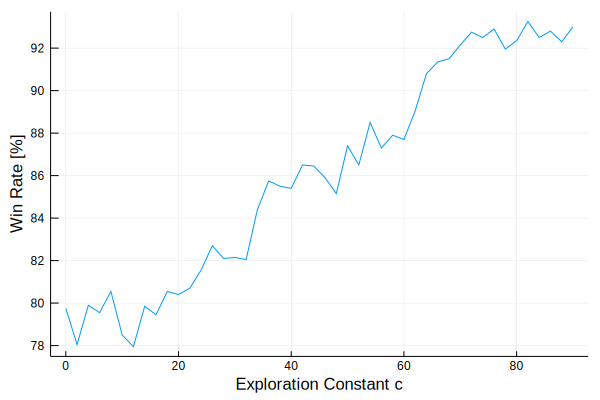

In [36]:
@time varyC(0.0:2.0:100.0, 3, 2000, 15)

1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,
248.134774 seconds (2.51 G allocations: 51.648 GiB, 6.05% gc time)


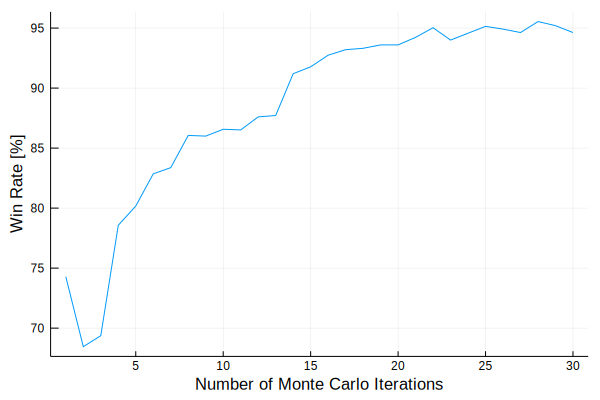

In [34]:
@time varyNumIterations(1:1:30, 3, 1750, 65.0)

### 4x4

In [ ]:
@time varyC(0.0:20.0:220.0, 4, 750, 25)

1,3,5,7,9,11,13,15,17,19,21,23,25,27,
497.726723 seconds (2.73 G allocations: 70.015 GiB, 49.24% gc time)


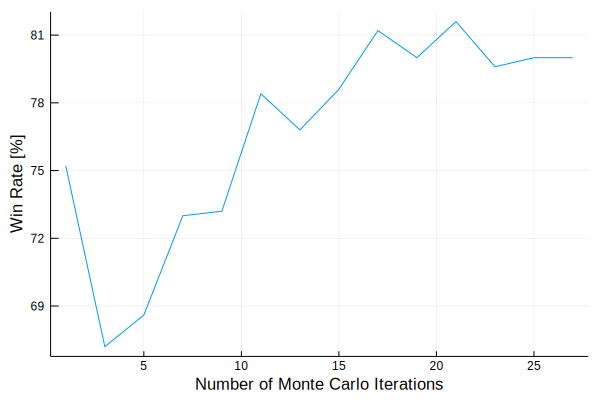

In [34]:
@time varyNumIterations(1:2:27, 4, 500, 80.0)

### 5x5

In [ ]:
# @time varyC(0.0:50.0:200.0, 5, 20, 500)

In [ ]:
# Ideal C = 100.0
# @time varyNumIterations(100:100:1100, 5, 20, 100.0)

### Timing

In [59]:
n = 3
gameSim = getNewGameSim(80.0, 0.9, 25)
boardInstance = getFirstBoardInstance(n)
cache = createCache()
@time selectAction(gameSim, boardInstance, cache)

n = 4
gameSim = getNewGameSim(175.0, 0.9, 25)
boardInstance = getFirstBoardInstance(n)
cache = createCache()
@time selectAction(gameSim, boardInstance, cache)

n = 5
gameSim = getNewGameSim(300.0, 0.9, 25)
boardInstance = getFirstBoardInstance(n)
cache = createCache()
@time selectAction(gameSim, boardInstance, cache)

  0.005081 seconds (50.09 k allocations: 1.690 MiB)
  0.018101 seconds (204.66 k allocations: 7.312 MiB)
  0.446723 seconds (729.93 k allocations: 27.327 MiB, 87.80% gc time)


CartesianIndex(2, 1)

In [56]:
# @time runSimulation(80.0, 25, 1000, 3, createCache())
# @time runSimulation(175.0, 25, 500, 4, createCache())
# @time runSimulation(300.0, 25, 100, 5, createCache())

 62.013757 seconds (386.69 M allocations: 10.286 GiB, 51.09% gc time)


83.0